# New York City Taxi Trip Duration

<a id=problem></a>
# The Problem
***
Build a model to predict the duration of NYC taxi trip.

# Data fields
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## Import libraries¶


In [1]:
#The library we use
# data analysis and wrangling
import pandas as pd
import numpy as np
from numpy import math
import random as rnd
from haversine import haversine
import calendar

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## Import Dataset¶


In [2]:
#import the data from a csv file.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [107]:
#Take look at train data
train.head(3)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [108]:
#cheack up if there is missing data and know the data type for each columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


<a id=problem></a>
# Feature engineering



In [109]:
#Change type for date time columns from object to datetime
train['pickup_datetime']= pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime']= pd.to_datetime(train['pickup_datetime'])

In [110]:
#Check the type of each variable
train.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,object
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [111]:
#create derived features from date time columns
def new_features(data,colunms='pickup_datetime'):
    data['hour']=data['pickup_datetime'].apply(lambda x:x.hour)
    data['minute']=data['pickup_datetime'].apply(lambda x:x.minute)
    data['month']=data['pickup_datetime'].apply(lambda x:calendar.month_name[x.month])
    data['weekday']=data['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    return

In [112]:
new_features(train)
new_features(test)

In [113]:
#Create new feature from hour column
def get_part_of_day(hour):
    val = ''
    if hour in [6,7,8,9,10]:
        val = 'moring'
    elif hour in [11,12,13,14,15]:
        val = 'noon' 
    elif hour in [16,17,18,19]:
        val = 'evening'
    else:
        val = 'night'    
    return val

In [114]:
train['pod']=train['hour'].apply(get_part_of_day)
test['pod']=test['hour'].apply(get_part_of_day)

In [115]:
#Find distace by using pickup,droppoff longitude and latitude by use haversine library
def calc_distance(data):
    pickup = (data['pickup_latitude'], data['pickup_longitude'])
    drop = (data['dropoff_latitude'], data['dropoff_longitude'])
    return haversine(pickup, drop)

In [116]:
train['distance'] = train.apply(lambda x: calc_distance(x), axis = 1)
test['distance'] = test.apply(lambda x: calc_distance(x), axis = 1)

In [117]:
#Delete pickup datetime column after feature engineering
train.drop('pickup_datetime',axis=1,inplace=True)
test.drop('pickup_datetime',axis=1,inplace=True)

<a id=problem></a>
# Remove outlier from data

Passengers
New York City Taxi Passenger Limit says:

- A maximum of 4 passengers can ride in traditional cabs, there are also 5 passenger cabs that look more like minivans.
- A child under 7 is allowed to sit on a passenger's lap in the rear seat in addition to the passenger limit.
- in total we can assume that maximum 6 passenger can board the new york taxi i.e. 5 adult + 1 minor

In [118]:
train.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

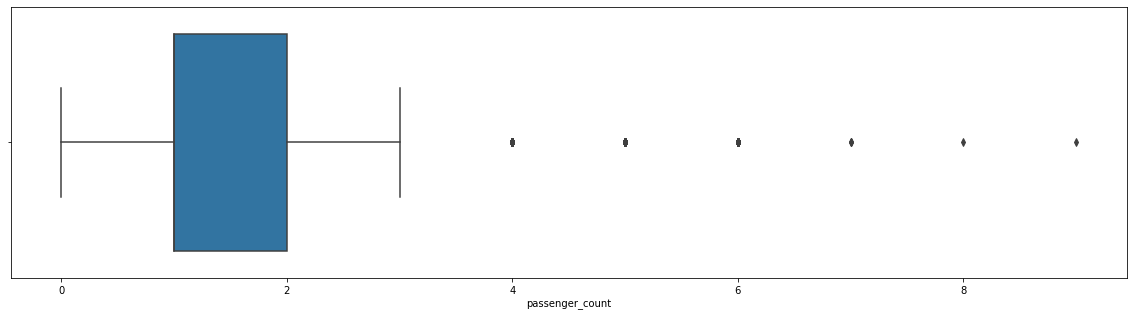

In [119]:
plt.figure(figsize = (20,5))
sns.boxplot(train.passenger_count)
plt.show()

observations:
- There are some trips with 0 passenger count.
- Few trips consisted of even 7, 8 or 9 passengers. Clear outliers and pointers to data inconsistency
- Most of trip consist of passenger either 1 or 2.


In [120]:
train.passenger_count.describe()


count    1.458644e+06
mean     1.664530e+00
std      1.314242e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.000000e+00
Name: passenger_count, dtype: float64

- As per above details. Mean median and mode are all approx equal to 1. So we would replace the 0 passenger count with 1.



#### will remove the records with passenger count > 7, 8 or 9 as they are extreme values and looks very odd to be ocupied in a taxi.



In [121]:
train['passenger_count'] = train.passenger_count.map(lambda x: 1 if x == 0 else x)
train = train[train.passenger_count <=6]

In [122]:
train.passenger_count.value_counts()


1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

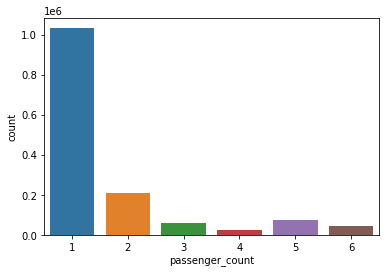

In [123]:
sns.countplot(train.passenger_count)
plt.show()

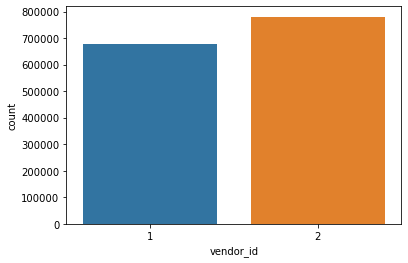

In [124]:
sns.countplot(train.vendor_id)
plt.show()

In [125]:
print(train.distance.describe())


count    1.458639e+06
mean     3.440876e+00
std      4.296547e+00
min      0.000000e+00
25%      1.231841e+00
50%      2.093727e+00
75%      3.875344e+00
max      1.240910e+03
Name: distance, dtype: float64


# There some trips with over 100 km distance.
- Some of the trips distance value is 0 km.
# Observations:
- mean distance travelled is approx 3.5 kms.
- standard deviation of 4.3 which shows that most of the trips are limited to the range of 1-10 kms.

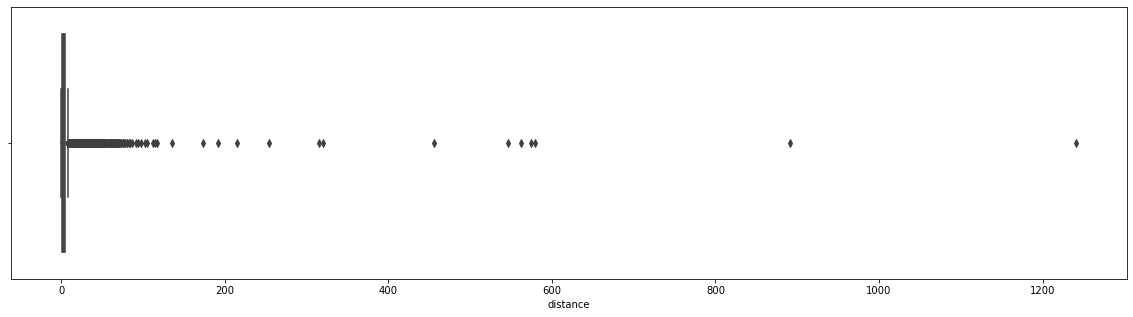

In [126]:
plt.figure(figsize = (20,5))
sns.boxplot(train.distance)
plt.show()

In [127]:
print("There are {} trip records with 0 km distance".format(train.distance[train.distance == 0 ].count()))


There are 5895 trip records with 0 km distance


In [128]:
train[train.distance == 0 ].head()


,id,vendor_id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,minute,month,weekday,pod,distance
246,id3487442,2,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,18,39,February,Monday,evening,0.0
291,id0924324,2,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,18,7,May,Tuesday,evening,0.0
407,id1145809,2,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,23,15,May,Monday,night,0.0
702,id3499387,1,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,19,45,January,Monday,evening,0.0
1620,id0753277,1,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,22,29,January,Wednesday,night,0.0


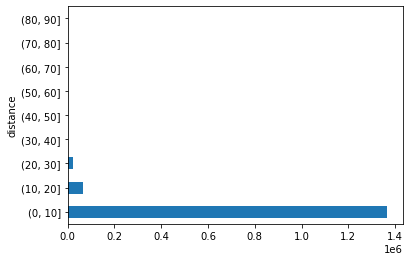

In [129]:
train.distance.groupby(pd.cut(train.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

- From the above observation it is evident that most of the rides are completed between 1-10 Kms with some of the rides with distances between 10-30 kms. Other slabs bar are not visible because the number of trips are very less as compared to these slabs


In [130]:
train.trip_duration.describe(percentiles=[0.75,0.90])

count    1.458639e+06
mean     9.594951e+02
std      5.237440e+03
min      1.000000e+00
50%      6.620000e+02
75%      1.075000e+03
90%      1.634000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

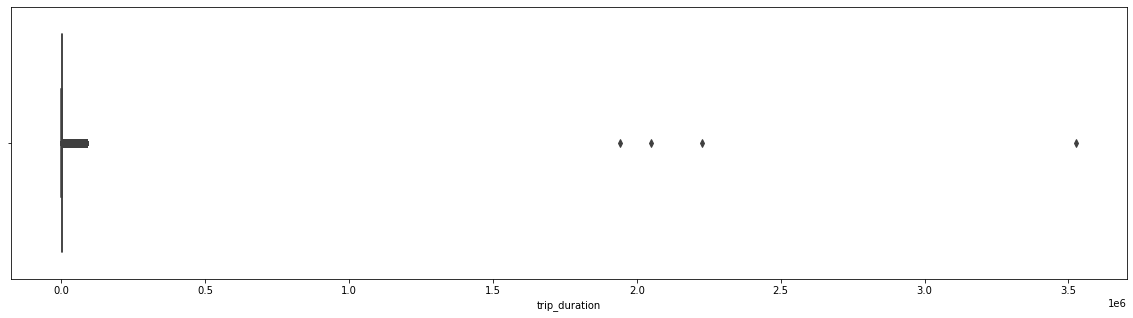

In [131]:
plt.figure(figsize = (20,5))
sns.boxplot(train.trip_duration)
plt.show()

# Observations:
- There are some durations with as low as 1 second. which points towards trips with 0 km distance.
- Major trip durations took between 10-20 mins to complete.
- Mean and mode are not same which shows that trip duration distribution is skewed towards right.

In [132]:
train.trip_duration.groupby(pd.cut(train.trip_duration, np.arange(1,max(train.trip_duration),1000))).count()

trip_duration
(1, 1001]             1045739
(1001, 2001]           328580
(2001, 3001]            60497
(3001, 4001]            15499
(4001, 5001]             4518
                       ...   
(3521001, 3522001]          0
(3522001, 3523001]          0
(3523001, 3524001]          0
(3524001, 3525001]          0
(3525001, 3526001]          0
Name: trip_duration, Length: 3526, dtype: int64

In [133]:
train = train[train.trip_duration <= 100]

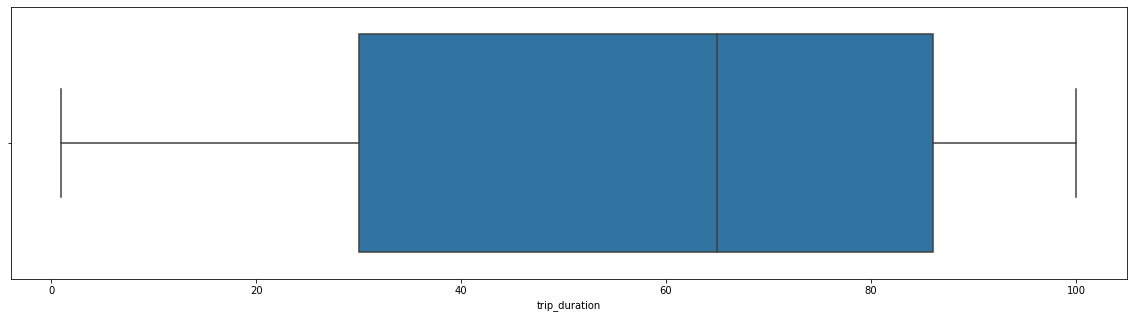

In [134]:
plt.figure(figsize = (20,5))
sns.boxplot(train.trip_duration)
plt.show()

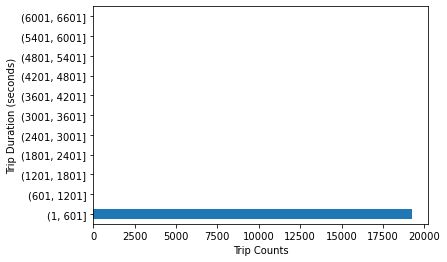

In [135]:
train.trip_duration.groupby(pd.cut(train.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

- We can observe that most of the trips took 0 - 20  mins to complete i.e. approx 1200 secs. 

<a id=bivariate></a>
# Bivariate Analysis
***
Bivariate analysis is used to find out if there is a relationship between two sets of values. It usually involves the variables X and Y.

<a id=hour_duration></a>
## Trip Duration per hour

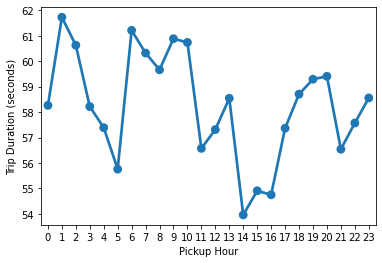

In [136]:
group1 = train.groupby('hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

Observations:
- Average trip duration is lowest at 6 am.
- Average trip duration is generally highest around 3 pm during the busy streets.
- Trip duration on an average is similar during early morning hours i.e. before 6 AM & late evening hours i.e. after 6 PM.

<a id=week_duration></a>
## Trip duration per weekday

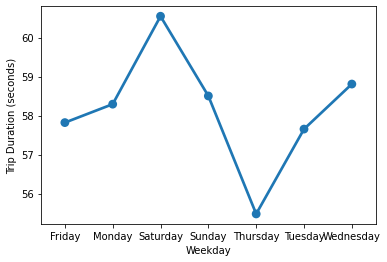

In [137]:
group2 = train.groupby('weekday').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

Observation

We can see that trip duration is almost equally distributed across the week on a scale of 0-1000 minutes with minimal difference in the duration times. Also, it is observed that trip duration on thursday is longest among all days.

<a id=month_distance></a>
## Distance per month

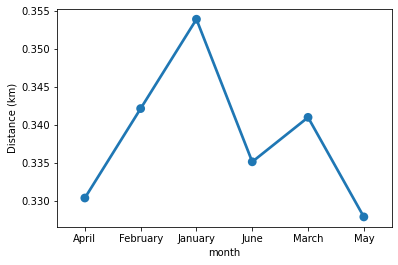

In [138]:
group3 = train.groupby('month').distance.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Distance (km)')
plt.show()

Observation

Here also the distibution is almost equivalent, varying mostly around 3.5 km/h with 5th month being the highest in the average distance and 2nd month being the lowest.

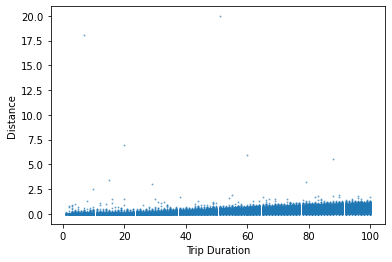

In [139]:
dur_dist = train.loc[(train.distance < 50) & (train.trip_duration < 1000), ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

- We should remove those trips which covered 0 km distance but clocked more than 1 minute to make our data more consistent for predictive model. 

In [140]:
train = train[~((train.distance == 0) & (train.trip_duration >= 60))]

In [141]:
duo = train.loc[(train['distance'] <= 1) & (train['trip_duration'] >= 3600),['distance','trip_duration']].reset_index(drop=True)

- Now, Instead of looking at each and every trip, we should approximate and try to filter those trips which covered less than 1 km distance and but clocked more than an hour.

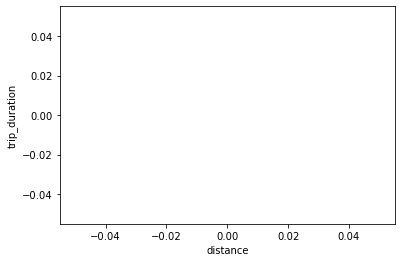

In [142]:
sns.regplot(duo.distance, duo.trip_duration)
plt.show()

<a id=week_distance></a>
## Distance per weekday

So it's a fairly equal distribution with average distance metric verying around 3.5 km/h with Sunday being at the top may be due to outstation trips or night trips towards the airport.

<a id=hot_encoding></a>
## Hot encoding

In [143]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday,pod ,hour, passenger_count" 
def hot_encoding(data):
    cols=['vendor_id','month','hour','weekday','pod','store_and_fwd_flag']
    
    vendor_id=['vendor_id'+str(i) for i in [1,2]]
    month=['month'+str(i) for i in['March','June','January','April','May','February']]
    hour=['hour_pickup'+str(x) for x in range(0,24)]
    weekday=['weekday'+str(i) for i in['Monday', 'Sunday', 'Tuesday', 'Wednesday', 'Saturday', 'Friday','Thursday']]
    pod=['pod'+str(i) for i in['morning','noon','evening','night']]
    store_and_fwd_flag=['store_and_fwd_flag'+str(i) for i in ['N','Y']]
    full_columns=hour+pod+store_and_fwd_flag+month+vendor_id+weekday
    
    vendor=pd.get_dummies(data.vendor_id,prefix='vendor_id')
    month=pd.get_dummies(data.month,prefix='month')
    hour=pd.get_dummies(data.hour,prefix='hour')
    weekday=pd.get_dummies(data.weekday,prefix='weekday')
    pod=pd.get_dummies(data.pod,prefix='pod')
    store_and_fwd_flag=pd.get_dummies(data.store_and_fwd_flag,prefix='store_and_fwd_flag')
    df=pd.DataFrame(['vendor','month','hour','weekday','pod','store_and_fwd_flag'])

    
    df_dummies=df.T.reindex(full_columns).T.fillna(0)
    df=data.drop(cols,axis=1)
    df=pd.concat([df,vendor,month,hour,weekday,pod,store_and_fwd_flag],axis=1)
    
    return df

In [144]:
train=hot_encoding(train)
test=hot_encoding(test)


In [145]:
train.shape

(19094, 55)

In [146]:
test.shape

(625134, 53)

In [147]:
train.head(3)

,id,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,minute,distance,...,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,pod_evening,pod_moring,pod_night,pod_noon,store_and_fwd_flag_N,store_and_fwd_flag_Y
72,id1510700,2016-02-20 21:59:10,1,-73.958397,40.772629,-73.955132,40.774242,57,58,0.328333,...,0,0,0,0,0,0,1,0,1,0
199,id2000923,2016-03-29 06:09:03,5,-73.987869,40.765099,-73.993607,40.758949,85,7,0.837277,...,0,0,1,0,0,1,0,0,1,0
317,id3482709,2016-03-21 11:24:00,1,-73.955193,40.779991,-73.957802,40.776508,72,22,0.445252,...,0,0,0,0,0,0,0,1,1,0


In [148]:
test.head(3)

,id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,minute,distance,vendor_id_1,vendor_id_2,...,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,pod_evening,pod_moring,pod_night,pod_noon,store_and_fwd_flag_N,store_and_fwd_flag_Y
0,id3004672,1,-73.988129,40.732029,-73.990173,40.756680,24,2.746430,1,0,...,0,0,0,0,1,0,0,0,1,0
1,id3505355,1,-73.964203,40.679993,-73.959808,40.655403,43,2.759243,1,0,...,1,0,0,0,0,0,1,0,1,0
2,id1217141,1,-73.997437,40.737583,-73.986160,40.729523,35,1.306157,1,0,...,0,0,1,0,0,0,0,1,1,0


In [149]:
#Create csv file after hot encoding
train.to_csv('train_feature.csv', index=False)
test.to_csv('test_feature.csv', index=False)

In [10]:
#Delete useless columns
train.drop(['dropoff_datetime','id'],axis=1,inplace=True)
id_test=test['id']
test.drop(['id'],axis=1,inplace=True)

In [151]:
train.shape

(19094, 53)

In [152]:
test.shape

(625134, 52)

In [153]:
train.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,minute,distance,vendor_id_1,vendor_id_2,...,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,pod_evening,pod_moring,pod_night,pod_noon,store_and_fwd_flag_N,store_and_fwd_flag_Y
72,1,-73.958397,40.772629,-73.955132,40.774242,57,58,0.328333,0,1,...,0,0,0,0,0,0,1,0,1,0
199,5,-73.987869,40.765099,-73.993607,40.758949,85,7,0.837277,0,1,...,0,0,1,0,0,1,0,0,1,0
317,1,-73.955193,40.779991,-73.957802,40.776508,72,22,0.445252,0,1,...,0,0,0,0,0,0,0,1,1,0
321,1,-73.981400,40.778793,-73.976524,40.782497,93,28,0.581496,0,1,...,0,0,0,0,0,0,1,0,1,0
323,1,-74.001030,40.756653,-74.000999,40.756626,40,22,0.003927,1,0,...,0,0,0,0,0,0,0,1,1,0


<a id=model></a>
# Model
We need a model to train on our dataset to serve our purpose of prediciting the NYC taxi trip duration given the other features as training and test set. Since our dependent variable contains continous values so we will use regression technique to predict our output.

In [3]:
# put all features in train data in x and put the target variable(trip duration) as y to try the model
x = train.drop('trip_duration',axis=1)
y=train['trip_duration']

In [4]:
# Divide the x,y into test and train by using train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.30, random_state=0)

In [156]:
x.shape

(19094, 52)

In [157]:
y.shape

(19094,)

<a id=lin_reg></a>
## Linear Regression
We will first try with the default instantiation of the regressor object without using any generalization parameter. We will also not perform any scaling of the features because linear regression model takes care of that inherently. This is a plus point to use Linear regression model. It is quite fast to train even on very large datasets. So considering the size of our dataset this seems to be the correct approach as of now. Let's see how it performs.

# Model evaluation

In [11]:
# Linear regressor for the split train data
model = LogisticRegression()

In [12]:
# Fit the model
model.fit(x_train,y_train)

ValueError: could not convert string to float: 'id2968130'

In [ ]:
pred_validate=model.predict(x_validate)
pred_validate

In [163]:
model.score(x_validate, y_validate)

0.43059186064601473

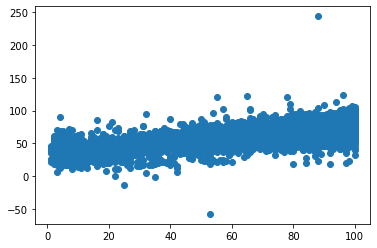

In [164]:
plt.scatter(y_validate,pred_validate)

In [165]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_validate, pred_validate))  

Mean Absolute Error: 19.872940594906233


In [167]:
prediction=model.predict(test)
prediction

array([165.19950494, 135.61286094,  96.47318413, ..., 388.12209383,
       960.856784  , 310.74987908])

In [ ]:
ybr.prediction_error(model.best_estimator_, X_train, y_train, X_val, y_val, is_fitted=True)


# Model criation 

In [168]:
# Linear regressor for the all train data
model_prediction = LinearRegression()

In [169]:
# Fit the model
model_prediction.fit(x,y)

LinearRegression()

In [170]:
# Cheack the accuracy of the model by use cross val score
model_prediction.score(x,y)

0.37309084012577565

In [171]:
# Model prediction 
prediction=model_prediction.predict(test)
prediction

array([ 175.90469448,  150.8966794 ,  100.25216795, ...,  425.4121798 ,
       1047.59748457,  334.69713911])

In [172]:
# Create data frame use the id for test data and prediction
prediction=pd.DataFrame({"id":id_test,"trip_duration":prediction})
prediction.head()

,id,trip_duration
0,id3004672,175.904694
1,id3505355,150.896679
2,id1217141,100.252168
3,id2150126,267.830326
4,id1598245,88.524436


In [173]:
# Create csv file
prediction.to_csv('predict',index=False)

In [182]:
from sklearn.metrics import classification_report, confusion_matrix

param_grid = {'C':[0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}

In [ ]:
x_train, x_validate, y_train, y_validate

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 4)
grid.fit( x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.021 total time= 1.2min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.021 total time= 1.1min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.021 total time= 1.2min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.021 total time= 1.2min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.021 total time= 1.1min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.021 total time=  51.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.021 total time=  57.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.021 total time=  54.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.021 total time=  50.6s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.021 total time=  51.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.021 total time=  48.2s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;

In [ ]:
y_pred = svm.predict(x_validate)
y_pred